## Case study: L-valine production in _E. coli_

[Hao et al. (2020)](https://doi.org/10.1016/j.ymben.2020.09.007) achieved impressive valine titers (84 g/L), substrate yield (0.41 g/g glucose) and average volumetric productivity (2.33 g/(Lh)) in a two stage fed-batch process of an engineered _E. coli_ strain.
After the batch, in the first stage of the feed phase, cells were allowed to grow under aerobic conditions to an OD600 of approximately 100. Then, aeration was turned off for the microaerobic production stage.
Growth essentially stopped during the microaerobic stage, but valine production continued.
While they also got high high titers for a fully aerobic one-stage fed-batch process (86 g/L), substrate yield and productivity was considerably lower (0.33 g/g glucose and 1.95 g/(Lh), respectively).
Below we will use their data to demonstrate how to obtain the parameters required to optimize the two stage process using our framework.

The following parameters can be taken directly from the paper:
- `V_batch`: batch volume
- `s_f`: glucose feed concentration
- `Y_PS`: maximum valine yield on glucose

Further, we will use the data from Fig. 5 (which we extracted using an online tool for digitizing plots) to fit (among other things):

- `X_batch`: total biomass after the batch
- `V_max`: maximum reactor volume (batch and feed volume should not exceed this value)
- `pi_0_aerob`: growth-independent production rate in aerobic conditions
- `pi_1_aerob`: growth-associated production rate in aerobic conditions
- `pi_0_microaerob`: growth-independent production rate in microaerobic conditions

> Note: `pi_1` in the microaerobic stage is irrelevant as growth is assumed to be negligible

Other relevant parameters can be found in the literature.
We rely on [Klamt et al. (2018)](https://doi.org/10.1002/biot.201700539)'s seminal work on one-stage vs. two-stage processes for _E. coli_ for:

- `Y_XS`: biomass yield on glucose
- `rho`: maintenance coefficient
- `Y_AS`: ATP yield on glucose

We will then use this collection of parameters in the web tool to optimize the time of the switch from aerobic to microaerobic conditions and show that considerably higher productivity is possible (at the cost of lower titers).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

import sys

sys.path.append("../../FedBatchDesigner")
from process_stages import ConstantStageIntegrate

Let's start by loading the data.

In [11]:
# we assume 1 OD = 0.33 g/L CDW
# (https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=109838)
OD_to_x = 0.33
# read the figure data
df_5A_orig = pd.read_csv("data-from-fig-5A.csv", index_col=0)
df_5B_orig = pd.read_csv("data-from-fig-5B.csv", index_col=0)
df_5A_orig.columns = ["p", "OD"]
df_5B_orig.columns = ["p", "OD"]
# drop the batch (we assume it took 4 hours) from both processes and calculate the
# biomass concentration
df_5A, df_5B = [
    df.loc[4:]
    .eval("x = OD * @OD_to_x")
    .reset_index(names="t_total")
    .eval("t = t_total - 4")
    .set_index("t")
    for df in [df_5A_orig, df_5B_orig]
]

Some process and physiological parameters we already know from the paper or the literature.
The amount of biomass and valine after the batch has been measured, but we still include this in the fit as the measurements might include some error.
For the least squares parameter estimation, we need values of the biomass and product concentrations.
We'll therefore put those (and the time points) into `numpy` arrays to use later.

In [12]:
# put the parameters that we already know into a dict (the process stage classes expect
# them in dicts)
params = {
    "s_f": 800,  # g/L (from paper and confirmed by correspondence with the authors)
    "rho": 7.7e-3 * 507,  # g ATP / (g CDM h) (Klamt et al. 2018)
    "Y_XS": 98 / 180,  # g CDW / g glc (Klamt et al. 2018)
    "Y_AS": 23.5 * 507 / 180,  # g ATP / g glc (Klamt et al. 2018)
    "Y_PS": 0.65,  # g valine / g glc (theoretical maximum)
}

# we also know that the batch medium was 3 L and can calculate the amount of biomass and
# valine after the batch (the measurements could have some error; we thus include these
# parameters in the fit as well, but will use the measured values as initial guesses)
V_batch = 3
X0_guess_5A = df_5A["x"].values[0] * V_batch
P0_guess_5A = df_5A["p"].values[0] * V_batch
X0_guess_5B = df_5B["x"].values[0] * V_batch
P0_guess_5B = df_5B["p"].values[0] * V_batch

# total reactor volume was 5 L; let's guess the feed rates for the one-stage and the
# first (aerobic) stage in the two-stage process (assuming 1 L feed medium for the
# one-stage process and 0.5 L for the aerobic stage of the two-stage process)
F_guess_5A = 1 / df_5A.index[-1]
F_5B_s1_guess = 0.5 / df_5B.index[-1]

# true values for calculating the residuals below
t_5A = df_5A.index.values
y_true_5A = df_5A[["x", "p"]].values
t_5B = df_5B.index.values
y_true_5B = df_5B[["x", "p"]].values

We define two functions to predict biomass and product concentrations (based on the parameters we want to fit) in the fully aerobic one-stage and the two-stage process (with microaerobic second stage).

These are then called by the function that calculates the residuals between the predicted and the measured values.
We then use `scipy.least_squares()` to fit the parameters to the data.

Some important notes on the parameters used for the microaerobic stage: Our framework generally assumes that some of the substrate is used up for maintenance (e.g. glucose being completely turned into water and CO<sub>2</sub> under aerobic conditions) and that the amount of substrate required for this is given by $X\cdot\frac{\rho}{Y_{A/S}}$.

Hao et al., however, engineered their _E. coli_ strain to use valine biosynthesis to regenerate NAD+ under anaerobic conditions (which could be called valine fermentation).
Therefore, none of the substrate is actually fully consumed for maintenance in the second stage (the glucose is just turned into pyruvate which is then the substrate for valine production).
To reflect this in our framework, we set the maintenance parameter `rho` to 0.
The growth-coupled production parameter `pi_1` is also set to 0, as no growth is expected in the second stage.
To prevent growth, the yield of biomass on substrate (`Y_XS`) is set to a very low value to avoid numerical issues (the code would otherwise try to divide by zero).
The yield of valine on substrate (`Y_PS`) is set to 0.46, as reported in the paper.
The difference to the theoretical maximum is due to succinate accumulation (27 g/L) in the anaerobic
phase.


In [13]:
def predict_5A(t, X0, P0, pi_0, pi_1, F):
    """Predict biomass and valine concentrations for the one-stage aerobic process."""
    stage = ConstantStageIntegrate(
        V0=V_batch,
        X0=X0,
        P0=P0,
        stage_params=params | {"pi_0": pi_0, "pi_1": pi_1},
    )
    pred = stage.evaluate_at_t(t, F=F)[["V", "X", "P"]]
    pred = pred.eval("x = X / V").eval("p = P / V")
    return pred


def predict_5B(t, X0, P0, pi_0_aerob, pi_1_aerob, pi_0_microaerob, F):
    """
    Predict biomass and valine concentrations for the two-stage process with
    microaerobic second stage.
    """
    # aeration was turned off after 16 hours of total process time (i.e. 12 hours into
    # the feed phase)
    t_s1 = t[t <= 12]
    t_s2 = t[t > 12] - 12
    # define process stage class with constant feed rate for first stage
    s1 = ConstantStageIntegrate(
        V0=V_batch,
        X0=X0,
        P0=P0,
        stage_params=params | {"pi_0": pi_0_aerob, "pi_1": pi_1_aerob},
    )
    pred_s1 = s1.evaluate_at_t(t_s1, F=F)
    if t_s2.size > 0:
        # microaerobic second stage
        s2 = ConstantStageIntegrate(
            V0=pred_s1["V"].iloc[-1],
            X0=pred_s1["X"].iloc[-1],
            P0=pred_s1["P"].iloc[-1],
            stage_params=params
            | {
                "pi_0": pi_0_microaerob,
                "pi_1": 0,  # no growth in stage 2 and thus no growth-coupled production
                "rho": 0,  # ignore maintenance in stage 2
                "Y_PS": 0.46,  # from paper
                # TODO: set the below to 0 once we handle it properly
                "Y_XS": 1e-9,  # no growth in stage 2
            },
        )
        pred_s2 = s2.evaluate_at_t(t_s2, F=F)
        pred_s2.index += 12
        pred = pd.concat([pred_s1, pred_s2])
    else:
        pred = pred_s1
    pred = pred.eval("x = X / V").eval("p = P / V")
    return pred


def get_residuals(params_to_fit, return_predictions=False):
    """Calculate residuals for both processes."""
    (
        pi_0_aerob,
        pi_1_aerob,
        pi_1_microaerob,
        X0_5A,
        P0_5A,
        F_5A,
        X0_5B,
        P0_5B,
        F_5B_s1,
    ) = params_to_fit
    pred_5A = predict_5A(t_5A, X0_5A, P0_5A, pi_0_aerob, pi_1_aerob, F_5A)
    pred_5B = predict_5B(
        t_5B, X0_5B, P0_5B, pi_0_aerob, pi_1_aerob, pi_1_microaerob, F_5B_s1
    )
    if return_predictions:
        return pred_5A, pred_5B
    residuals_5A = (pred_5A[["x", "p"]].values - y_true_5A).ravel()
    residuals_5B = (pred_5B[["x", "p"]].values - y_true_5B).ravel()
    return np.concatenate([residuals_5A, residuals_5B])


(
    pi_0_aerob_fit,
    pi_1_aerob_fit,
    pi_0_microaerob_fit,
    X0_5A_fit,
    P0_5A_fit,
    F_5A_fit,
    X0_5B_fit,
    P0_5B_fit,
    F_5B_fit,
) = least_squares(
    fun=get_residuals,
    x0=[
        # initial guesses for the parameters
        0.1,  # pi_0_aerob
        0,  # pi_1_aerob
        0.1,  # pi_0_microaerob
        X0_guess_5A,  # X0_5A
        P0_guess_5A,  # P0_5A
        F_guess_5A,  # F_5A
        X0_guess_5B,  # X0_5B
        P0_guess_5B,  # P0_5B
        F_5B_s1_guess,  # F_5B
    ],
).x

Let's have a look at how well the fit matches the data for both processes.

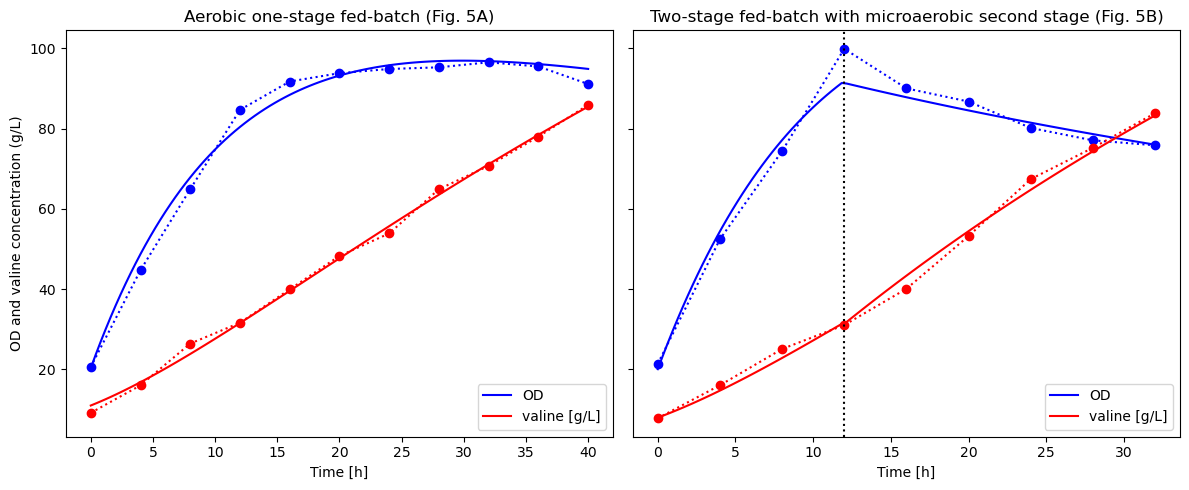

In [14]:
# use params from fit to predict 5A (fully aerobic one-stage process) and 5B (two-stage
# with microaerobic second stage)
pred_5A = predict_5A(
    t=np.linspace(t_5A[0], t_5A[-1], 101),
    X0=X0_5A_fit,
    P0=P0_5A_fit,
    pi_0=pi_0_aerob_fit,
    pi_1=pi_1_aerob_fit,
    F=F_5A_fit,
)
pred_5B = predict_5B(
    t=np.linspace(t_5B[0], t_5B[-1], 101),
    X0=X0_5B_fit,
    P0=P0_5B_fit,
    pi_0_aerob=pi_0_aerob_fit,
    pi_1_aerob=pi_1_aerob_fit,
    pi_0_microaerob=pi_0_microaerob_fit,
    F=F_5B_fit,
)
# plot the results
fig, (ax_5A, ax_5B) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

ax_5A.plot(df_5A.index, df_5A["OD"], "bo:")
ax_5A.plot(df_5A.index, df_5A["p"], "ro:")
ax_5A.plot(pred_5A.index, pred_5A["x"] / OD_to_x, "b-", label="OD")
ax_5A.plot(pred_5A.index, pred_5A["p"], "r-", label="valine [g/L]")
ax_5A.set_title("Aerobic one-stage fed-batch (Fig. 5A)")
ax_5A.set_ylabel("OD and valine concentration (g/L)")
ax_5A.set_xlabel("Time [h]")
ax_5A.legend(loc="lower right")

ax_5B.plot(df_5B.index, df_5B["OD"], "bo:")
ax_5B.plot(df_5B.index, df_5B["p"], "ro:")
ax_5B.plot(pred_5B.index, pred_5B["x"] / OD_to_x, "b-", label="OD")
ax_5B.plot(pred_5B.index, pred_5B["p"], "r-", label="valine [g/L]")
ax_5B.axvline(12, color="k", linestyle=":")
ax_5B.set_title("Two-stage fed-batch with microaerobic second stage (Fig. 5B)")
ax_5B.set_xlabel("Time [h]")
ax_5B.legend(loc="lower right")

fig.tight_layout()

This fits quite nicely!
The main discrepancy to the experimental data is with the measured OD600 at the switching point of the two-stage process.
However, the subsequent OD value decreased more quickly than what could be expected by dilution, which might suggest that this measurement was an outlier.

Also note that the difference on the time axis between the two processes (the two-stage process uses a higher feed rate and finishes more quickly, which leads to higher productivity).

In order to use our web tool, we still need the final volume (and the feed rate to select the reference process on the contour plots).
Let's extract these for both processes and print all relevant parameters.

In [15]:
V_end_5A = pred_5A["V"].iloc[-1]
V_end_5B = pred_5B["V"].iloc[-1]

print("common parameters:")
print(f"pi_0 aerobic:\t\t{pi_0_aerob_fit:.3g}")
print(f"pi_1 aerobic:\t\t{pi_1_aerob_fit:.3g}")

print("\nparameters for 5A:")
print(f"x after batch:\t\t{X0_5A_fit / V_batch:.3g}")
print(f"Feed rate:\t\t{F_5A_fit:.3g}")
print(f"Final volume:\t\t{V_end_5A:.3g}")

print("\nparameters for 5B:")
print(f"x after batch:\t\t{X0_5B_fit / V_batch:.3g}")
print(f"pi_0 microaerobic\t{pi_0_microaerob_fit:.3g}")
print(f"Feed rate:\t\t{F_5B_fit:.3g}")
print(f"Final volume:\t\t{V_end_5B:.3g}")

common parameters:
pi_0 aerobic:		0.073
pi_1 aerobic:		0.298

parameters for 5A:
x after batch:		6.7
Feed rate:		0.0292
Final volume:		4.17

parameters for 5B:
x after batch:		6.61
pi_0 microaerobic	0.114
Feed rate:		0.0345
Final volume:		4.1
